In [92]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from collections import Counter
from keras.preprocessing.text import text_to_word_sequence
from nltk.corpus import stopwords
# import nltk
# nltk.download('stopwords')
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding
from keras.callbacks import EarlyStopping

## Reference
https://www.kaggle.com/sterby/fasttext-like-baseline-with-keras-lb-0-056 

https://www.kaggle.com/CVxTz/keras-bidirectional-lstm-baseline-lb-0-051/code

https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/

In [5]:
dataset = pd.read_csv('./train.csv')

In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95851 entries, 0 to 95850
Data columns (total 8 columns):
id               95851 non-null int64
comment_text     95851 non-null object
toxic            95851 non-null int64
severe_toxic     95851 non-null int64
obscene          95851 non-null int64
threat           95851 non-null int64
insult           95851 non-null int64
identity_hate    95851 non-null int64
dtypes: int64(7), object(1)
memory usage: 5.9+ MB


In [7]:
dataset.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,22256635,"Nonsense? kiss off, geek. what I said is true...",1,0,0,0,0,0
1,27450690,"""\n\n Please do not vandalize pages, as you di...",0,0,0,0,0,0
2,54037174,"""\n\n """"Points of interest"""" \n\nI removed the...",0,0,0,0,0,0
3,77493077,Asking some his nationality is a Racial offenc...,0,0,0,0,0,0
4,79357270,The reader here is not going by my say so for ...,0,0,0,0,0,0


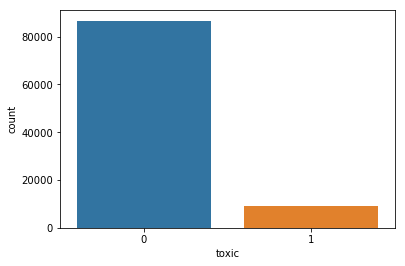

In [8]:
sns.countplot(dataset.toxic)

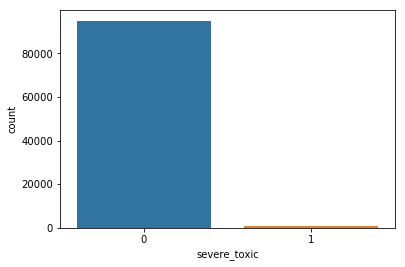

In [9]:
sns.countplot(dataset.severe_toxic)

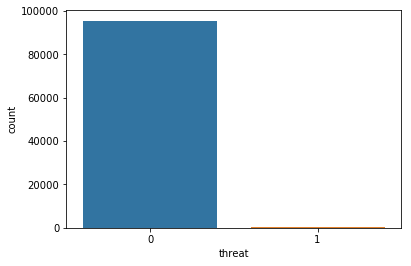

In [10]:
sns.countplot(dataset.threat)

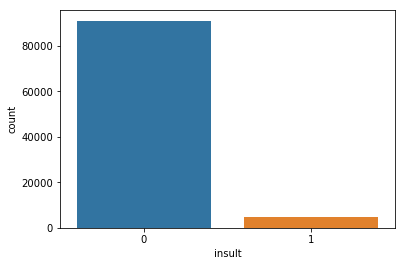

In [11]:
sns.countplot(dataset.insult)

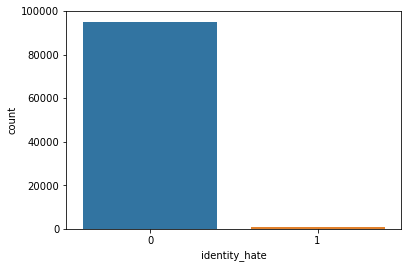

In [12]:
sns.countplot(dataset.identity_hate)

In [13]:
len([x for x in dataset.iloc[:,[2,3,4,5,6,7]].sum(axis=1).tolist() if x!=0])*100/len(dataset)

dataset['good'] = [1 if x==0 else 0 for x in dataset.iloc[:,[2,3,4,5,6,7]].sum(axis=1).tolist() ]

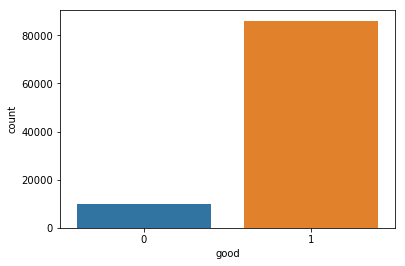

In [14]:
sns.countplot(dataset.good)

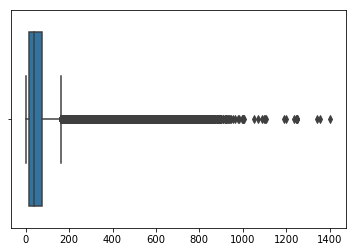

In [15]:
wordcounts = [len(x.split()) for x in dataset.comment_text]
max_comment_length = max(wordcounts)
sns.boxplot(wordcounts)

In [16]:
dataset.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,good
0,22256635,"Nonsense? kiss off, geek. what I said is true...",1,0,0,0,0,0,0
1,27450690,"""\n\n Please do not vandalize pages, as you di...",0,0,0,0,0,0,1
2,54037174,"""\n\n """"Points of interest"""" \n\nI removed the...",0,0,0,0,0,0,1
3,77493077,Asking some his nationality is a Racial offenc...,0,0,0,0,0,0,1
4,79357270,The reader here is not going by my say so for ...,0,0,0,0,0,0,1


In [18]:
X = dataset.comment_text
y = dataset.iloc[:,[2,3,4,5,6,7,8]]

In [20]:
stop_words = set(stopwords.words('english'))

In [46]:
print(X[2])
proc_text = text_to_word_sequence(X[2],filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',lower=True,split=" ")
# stopwords
# [word for word in proc_text if word not in stop_words]
print(proc_text)

"

 ""Points of interest"" 

I removed the ""points of interest"" section you added because it seemed kind of spammy. I know you probably didn't mean to disobey the rules, but generally, a point of interest tends to be rather touristy, and quite irrelevant to an area culture. That's just my opinion, though.

If you want to reply, just put your reply here and add {{talkback|Jamiegraham08}} on my talkpage.   "
['points', 'of', 'interest', 'i', 'removed', 'the', 'points', 'of', 'interest', 'section', 'you', 'added', 'because', 'it', 'seemed', 'kind', 'of', 'spammy', 'i', 'know', 'you', 'probably', "didn't", 'mean', 'to', 'disobey', 'the', 'rules', 'but', 'generally', 'a', 'point', 'of', 'interest', 'tends', 'to', 'be', 'rather', 'touristy', 'and', 'quite', 'irrelevant', 'to', 'an', 'area', 'culture', "that's", 'just', 'my', 'opinion', 'though', 'if', 'you', 'want', 'to', 'reply', 'just', 'put', 'your', 'reply', 'here', 'and', 'add', 'talkback', 'jamiegraham08', 'on', 'my', 'talkpage']


In [52]:
comments = []
word_counter = Counter()

for comment in dataset.comment_text:
    proc_text = text_to_word_sequence(comment, filters='\'!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',lower=True,split=" ")
    # proc_text = [word for word in proc_text if word not in stop_words]
    word_counter.update(proc_text)
    comments.append(proc_text)

In [72]:
word_to_int = dict((word, key) for key, word in zip(range(len(word_counter)),word_counter))
print(word_to_int.get('cranborne',-1))

101457


In [76]:
X_ints = [[word_to_int.get(word) for word in words] for words in comments]
max_comment_length = max([len(words) for words in comments])
print(max_comment_length)

In [101]:
maxlen = 100
X_sequence = sequence.pad_sequences(X_ints, maxlen = maxlen)
X_sequence = np.array(X_sequence)
y = np.array(y)
print(X_sequence.shape)
print(y.shape)

(95851, 100)
(95851, 7)


In [102]:
X_train, X_test, y_train, y_test = train_test_split(X_sequence, y, test_size = 0.2)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(76680, 100)
(19171, 100)
(76680, 7)
(19171, 7)


In [103]:
embed_lenth = 128
max_features = 20000
batch_size = 32
maxlen = 100

rnn = Sequential()
rnn.add(Embedding(max_features, embed_lenth, input_length=X_sequence.shape[1]))
rnn.add(LSTM(128))
rnn.add(Dense(y.shape[1], activation='sigmoid'))
rnn.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [104]:
callbacks = []
rnn.fit(X_train, y_train, epochs=3, verbose=1, batch_size=batch_size, validation_data=(X_test, y_test))

Train on 76680 samples, validate on 19171 samples
Epoch 1/3
76680/76680 [==============================] - 398s - loss: 0.7685 - acc: 0.9037 - val_loss: 0.7218 - val_acc: 0.9024